# Empfehlungs-System basierend auf dem Yelp-Datensatz

## Ziel

Es soll ein Empfehlungs-System (recommender system) auf dem Yelp-Datensatz trainiert werden. Dieser Datensatz enthält 2,7 Millionen Bewertungen von verschiedensten Geschäften (z.B. Restaurants).

Bei Empfehlungs-Systemen gibt zwei grundsätzlich unterschiedliche Ansätze: 

1. content based recommendation 
2. collaborative filtering. 

Bei Ansatz 1 werden die Empfehlungen basierend auf Eigenschaften der Items gemacht (basierend auf ihrem "content"). Bei Ansatz 2 wird die Empfehlungs-Historie genutzt, um die Präferenzen der Nutzer und Eigenschaften der Items (in unserem Fall sind das die Geschäfte) abzuleiten und für die Vorhersage zu nutzen.

In diesem Notebook wird der Ansatz des collaborative filtering am Yelp-Datensatz ausprobiert. Dazu wird Apache Spark benutzt.

## Module importieren und Spark initialisieren

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import json
import numpy as np
import pandas as pd
import time
import itertools
import os
from functools import partial

import types as python_types
import pyspark
from pyspark.sql import functions as F, types, SparkSession
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import pylab as plt
import seaborn as sns
plt.style.use("seaborn-ticks")
sns.set_style("ticks")
%matplotlib inline

start_time = time.time()

In [3]:
sc = pyspark.SparkContext("local[*]")
sqlc = pyspark.SQLContext(sc)

In [4]:
%aimport utils

## Daten runterladen und extrahieren

Der Yelp Datensatz findet sich unter: <br>
https://www.yelp.com/dataset_challenge

Der Datensatz beinhaltet viele verschiedene Informationen, wie Beschreibungen und Kategorisierungen der Geschäfte oder Bewertungen von Geschäften durch die Nutzer von Yelp (im folgenden einfach als User bezeichnet). Für das collaborative filtering sind die Bewertungen von Interesse. Es gibt insgesamt 2,7 Million Bewertungen von 687 Tausend Nutzern und 86 Tausend Geschäften.

Die folgenden Routinen laden den Datensatz runter und extrahieren ihn (falls noch nicht geschehen).

In [5]:
utils.download_yelp_dataset(skip_when_exists=True)

In [6]:
utils.extract_yelp_dataset(skip_when_exists=True)

## Daten einlesen

Die Daten liegen im JSON-Format vor. Jede Zeile in der Datei ist ein JSON-Object. Im folgenden werden die Daten eingelesen.

In [7]:
lines = sc.textFile("data/yelp_academic_dataset_review.json")

In [8]:
def parse_json(line):
    row = json.loads(line)
    return (row["user_id"], row["business_id"], row["stars"], row["date"])

In [9]:
rows = lines.map(parse_json)

In [10]:
review_df = sqlc.createDataFrame(rows, ["user", "item", "rating", "date"])

In [11]:
review_df = review_df.withColumn("rating", F.col("rating").cast("float"))

In [12]:
review_df.cache()

DataFrame[user: string, item: string, rating: float, date: string]

In [13]:
review_df.show(5)

+--------------------+--------------------+------+----------+
|                user|                item|rating|      date|
+--------------------+--------------------+------+----------+
|PUFPaY9KxDAcGqfso...|5UmKMjUEUNdYWqANh...|   4.0|2012-08-01|
|Iu6AxdBYGR4A0wspR...|5UmKMjUEUNdYWqANh...|   5.0|2014-02-13|
|auESFwWvW42h6alXg...|5UmKMjUEUNdYWqANh...|   5.0|2015-10-31|
|qiczib2fO_1VBG8Io...|5UmKMjUEUNdYWqANh...|   3.0|2015-12-26|
|qEE5EvV-f-s7yHC0Z...|5UmKMjUEUNdYWqANh...|   2.0|2016-04-08|
+--------------------+--------------------+------+----------+
only showing top 5 rows



## Einige Übersichts-Statistiken

### Anzahl der Bewertungen

In [14]:
review_df.count()

2685066

### Anzahl der User und Items (Nutzer und Geschäfte)

In [15]:
review_df.agg(F.countDistinct("user"), F.countDistinct("item"), F.countDistinct("rating")).show()

+--------------------+--------------------+----------------------+
|count(DISTINCT user)|count(DISTINCT item)|count(DISTINCT rating)|
+--------------------+--------------------+----------------------+
|              686556|               85539|                     5|
+--------------------+--------------------+----------------------+



### Verteilung der Werte der Bewertungen

Der Wertebereich der Bewertungen ist 1 bis 5 Sterne. Man sieht, dass die Verteilung zu hohen Werten verschoben ist.

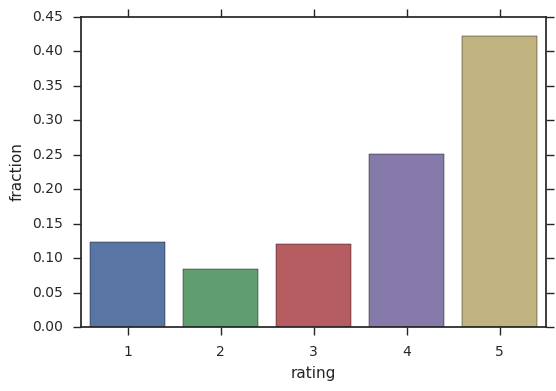

In [16]:
bins, counts = (review_df
                .select("rating")
                .rdd.keys()
                .histogram([1,2,3,4,5,6]))

utils.plot_histogram(bins, counts, xlabel="rating")
plt.savefig("plots/rating_histogram.pdf", bbox_inches="tight")

### Wie viele Bewertungen haben einzelne Items?

Das folgende Histogramm (linker Plot) zeigt die Verteilung der Anzahl der Bewertungen von Items. Man sieht z.B., dass ca. 1% der Items nur eine Bewertung haben (der erste Bin geht von 1 bis 2, wobei die obere Grenze ausgeschlossen ist) und ca. 20% der Items nur 2 bis 3 Bewertungen.

Die Grafik rechts zeigt die aufsummierte (kumulative) Verteilung. Man sieht dort z.B., dass ca. 65% aller Items weniger als 10 Bewertungen haben.

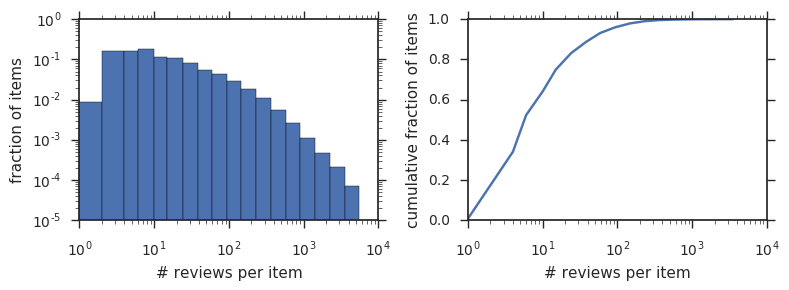

In [17]:
_ = utils.count_reviews(review_df, "item")
plt.savefig("plots/number_reviews_items.pdf", bbox_inches="tight")

### Wie viele Bewertungen haben einzelne User?

Die Verteilung der Anzahl der Bewertungen der User ist noch stärker zu wenigen Bewertungen verschoben: ca. 95% der User haben weniger als 10 Bewertungen abgegeben.

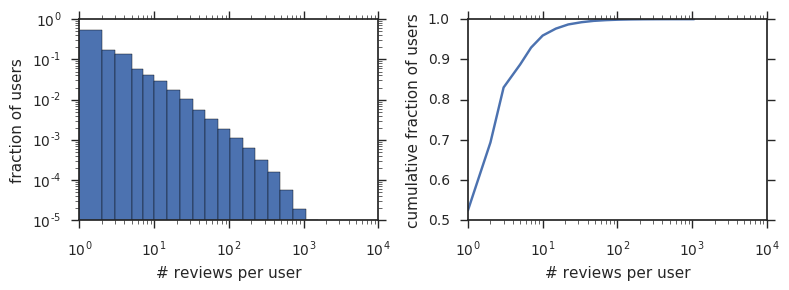

In [18]:
_ = utils.count_reviews(review_df, "user")
plt.savefig("plots/number_reviews_users.pdf", bbox_inches="tight")

### Verteilung der Bewertungen nach Datum

Wir sehen, dass die Bewertungen über einen Zeitraum vom 13 Jahren (2004 bis 2016) verteilt sind. Dabei nimmt die Anzahl der Bewertungen rapide zu.

In [19]:
review_df.agg(F.min("date"), F.max("date")).show()

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2004-10-12|2016-07-19|
+----------+----------+



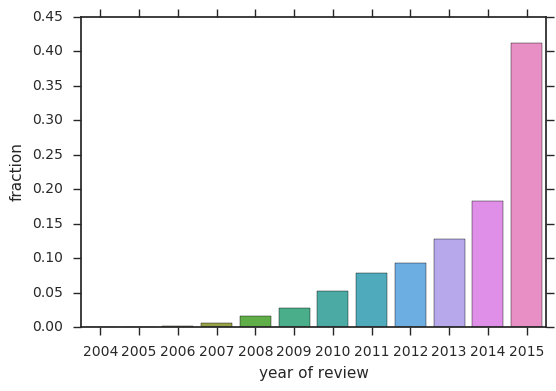

In [20]:
def get_year(s):
    return int(s[:4])

bins, counts = (review_df
                .select("date")
                .rdd.keys()
                .map(get_year)
                .histogram(list(range(2004, 2017))))

utils.plot_histogram(bins, counts, xlabel="year of review")
plt.savefig("plots/number_reviews_year.pdf", bbox_inches="tight")

### Zeitbereich einschränken

Für die folgende Analyse beschränken wir uns auf die Bewertungen in der Periode 2011-2015. Dies geschieht, um die Nicht-Stationarität des Problems zu reduzieren. Es ist nämlich wahrscheinlich, dass sich Meinungen und Bewertungen von Geschäften mit der Zeit verändern, z.B. Trend-Wechsel bei Restaurants. Durch das Einschränken vernachlässigen wir nur ca. 10% der Bewertungen, was durchaus akzeptabel ist.

In [21]:
year = F.udf(get_year, types.IntegerType())
n_old = review_df.count()
review_df = review_df.filter(year("date")>2010)
n_new = review_df.count()
print("# reviews between 2011 and 2015: ", n_new)
print("Outside of this range are {:.0f}% of reviews".format(100*(n_old-n_new)/n_old))

# reviews between 2011 and 2015:  2407455
Outside of this range are 10% of reviews


### Anmerkung

Es gibt Verfahren für Empfehlungs-Systeme, die die Nicht-Stationarität explizit berücksichtigen. Zum Beispiel wurde in [1] gezeigt, dass ein socher Ansatz siginifikante Verbesserungen der Vorhersagequalität liefern kann. Die Anzahl der Parameter dieser Modelle steigt jedoch enorm.

[1] Y. Koren, R. Bell, and C. Volinsky. Matrix factorization techniques for recommender systems. Computer, 42(8) 2009 <br>
http://www.columbia.edu/~jwp2128/Teaching/W4721/papers/ieeecomputer.pdf

## Datensatz auf Objekte mit eine Mindestanzahl von Bewertungen einschränken

Beim collaborative filtering werden Eigenschaften der Objekte (User und Items) von den Bewertungen abgeleitet. Hat ein Objekt nur wenige Bewertungen, ist zu erwarten, dass diese Ableitung wenig zuverlässig ist. Aus diesem Grund schränken wir im Folgenden den Datensatz auf Items mit mindestens 20 Bewertungen und User mit mindestens 10 Bewertunen ein. Die Grenzen für Items und User sind unterschiedlich gewählt, da Items generell mehr Bewertungen haben.

Durch die Einschränkung reduzieren wir die Anzahl der Bewertungen von 2,4 Million auf 0.9 Millionen. Durch die Einschränkung reduziert sich auch die Anzahl der Items und insbesondere der User (von ca. 686 Tausend auf 43 Tausend).

Ob der Datensatz eingeschränkt wird, lässt sich durch die Variable "restrict" steuern. Wir werden die Analyse auch ohne diese Einschränkung durchführen.

In [22]:
restrict = True
min_user_reviews = 10
min_item_reviews = 20

In [23]:
if restrict:
    reviews_per_user = review_df.groupBy("user").agg(F.count("rating").alias("user_reviews"))
    reviews_per_item = review_df.groupBy("item").agg(F.count("rating").alias("item_reviews"))
    
    review_df = (review_df
             .join(reviews_per_user, review_df["user"]==reviews_per_user["user"])
             .join(reviews_per_item, review_df["item"]==reviews_per_item["item"])
             .filter((F.col("user_reviews") >= min_user_reviews) & (F.col("item_reviews") >= min_item_reviews))
             .select(review_df["user"], review_df["item"], "rating", "date")
         )
    
    review_df.cache()

In [24]:
review_df.count()

938505

In [25]:
review_df.agg(F.countDistinct("user"), F.countDistinct("item"), F.countDistinct("rating")).show()

+--------------------+--------------------+----------------------+
|count(DISTINCT user)|count(DISTINCT item)|count(DISTINCT rating)|
+--------------------+--------------------+----------------------+
|               42893|               23012|                     5|
+--------------------+--------------------+----------------------+



## IDs numerisch machen

Die IDs der Objekte (Items und User) sind Strings. Das Alternating-Least-Squares Verfahren von Spark, dass wir im Folgenden benutzen wollen, setzt jedoch numerische IDs vorraus. Außerdem hat sich herausgestellt, dass große Sprünge in den IDs zu Problemen führen. Dies schließt z.B. eine Numerierung mit der Spark Funktion "monotonicallyIncreasingId" aus.

Im Folgenden werden die unique IDs bestimmt und von 0 an kontinuierlich durchnumeriert. Das DataFrame mit den Bewertungen (review_df) wird dann entsprechen angepasst. 

In [26]:
def make_mapping_to_id(df, column):
    mapping = (review_df
     .select(column)
     .distinct()
     .rdd
     .map(lambda r: r[0])
     .zipWithIndex()
    )
    
    mapping = sqlc.createDataFrame(mapping, [column, column + "_id"])
    mapping = mapping.select(column, F.col(column + "_id").cast(types.IntegerType()))
    return mapping

In [27]:
user_mapping = make_mapping_to_id(review_df, "user")
item_mapping = make_mapping_to_id(review_df, "item")

In [28]:
item_mapping.show(5)

+--------------------+-------+
|                item|item_id|
+--------------------+-------+
|-7Gvh1JVEZnEZ1DkE...|      0|
|-tCiAYMimz6yQaaXi...|      1|
|0Rrih6W3LGrNGB_3c...|      2|
|0h9vmm_oTd4edy5KN...|      3|
|10GBdcrKBSL1QFnkX...|      4|
+--------------------+-------+
only showing top 5 rows



In [29]:
review_df = (review_df
 .join(item_mapping, review_df.item==item_mapping.item)
 .join(user_mapping, review_df.user==user_mapping.user)
 .select(F.col("user_id").alias("user"), F.col("item_id").alias("item"), "rating", "date")
 )

In [30]:
review_df.cache()
review_df.show(5)

+----+-----+------+----------+
|user| item|rating|      date|
+----+-----+------+----------+
| 158| 2137|   2.0|2012-02-29|
| 158| 7722|   4.0|2011-12-02|
| 158|13040|   3.0|2011-12-12|
| 158|13274|   5.0|2012-02-17|
| 158|14431|   5.0|2012-02-17|
+----+-----+------+----------+
only showing top 5 rows



In [31]:
review_df_with_date = review_df

# drop date column
review_df = review_df.select("user", "item", "rating")
review_df.cache()

DataFrame[user: int, item: int, rating: float]

## Training-Test-Split für Kreuzvalidierung

Um die wirkliche Performance eines prädiktiven Verfahrens zu ermitteln, ist es essentiell diese auf einem Datensatz zu ermitteln, den das Verfahren beim Training nicht "gesehen" hat. Die Ursache dafür ist, dass bei der Anwendung von Verfahren mit vielen Parametern, fast immer Overfitting stattfindet. Das Verfahren lernt sozusagen den Datensatz auswendig und lernt keine generalisierbaren Zusammenhänge.

Im Folgenden wird der Datensatz in einen Training- und Test-Satz aufgeteilt. Die Vorhersageverfahren werden auf dem Trainings-Satz trainiert und deren Performance auf dem Test-Satz ermittelt. 

Hier benutzen wir die einfachste Form der Kreuzvalidierung: wir teilen den Datensatz nur einmal auf. Darüber hinaus gibt es fortgeschrittenere Verfahren, z.B. k-fold cross-validation, wobei die Aufteilung mehrmals gemacht und somit die Performance mehrmals ermittelt wird. Dadurch können die statistischen Schwankungen in Abhängigkeit des Datensatztes bestimmt werden. Bei Tests (die hier nicht gezeigt sind) hat sich ergeben, dass bei dem vorliegenden Datensatz die ermittelte Performance kaum bei unterschiedlichen Aufteilungen schwankt (bei einer 4-folg cross-validation lag die maximale Schwankung des RMSE bei ca. 0.003). 

In [32]:
train, test = review_df.randomSplit([0.75,0.25], seed=42)
train.cache()
test.cache()

DataFrame[user: int, item: int, rating: float]

Die Performance der Vorhersageverfahren messen wir im Folgenden mit dem sog. root-mean-square error:

\begin{equation}
RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}{(y_i-\hat{y}_i)^2}}
\end{equation}

Dabei ist sind $y_i$ die zu vorhersagenden Labels und $\hat{y}_i$ die Vorhersagen. $n$ ist die Größe des Datensatztes auf dem der RMSE ermittelt wird.

In [33]:
rmse = RegressionEvaluator(metricName="rmse", labelCol="rating")

## Trivialer Prädiktor

Hier wird die Mittelwert $\mu$ der Bewertungen ermittelt. Damit lassen sich auf eine ganz einfache Weise Vorhesagen tätigen, man sagt stets den Mittelwert vorher, also den *Erwartungswert*. Dieser Wert ist bezüglich des RMSE auch optimal, wenn man stets den selben Wert vorhersagen möchte.

Wir sehen, dass bei diesem trivialen Vorhersageverfahren sich ein RMSE von 1.227 ergibt. Dieser Wert soll im Folgenden als Baseline dienen, den jedes kompliziertere Verfahren sollte besser sein (andernfalls kann man das einfachere Verfahren einsetzen).

In [34]:
average_rating = train.agg(F.mean("rating")).first()[0]
average_rating

3.8047519223285526

In [35]:
rmse.evaluate(test.withColumn("prediction", F.lit(average_rating)))

1.2266461065425405

## Collaborative Filtering mit Matrix-Faktorisierung

In diesem Notebook wollen wir collaborative filltering mittels Matrix-Faktorisierung angehen, siehe z.B. [1]. Bei diesem Ansatz wird die Bewertungsmatrix $R_{ui}$ als Skalarprodukt Vektor modeliert, die die Eigenschaften der Items und die Präferenzen der User darstellen. Die Bewertungsmatrix $R_{ui}$ gibt die Bewertung an, die der User $u$ dem Item $i$ gegeben hat oder geben würde. Mit $\mathbf{Q}_u$ bezeichnen wir den Vektor, der die Präferenzen des Users $u$ kodiert und mit $\mathbf{P}_i$ die entsprechenden Eigenschaften des Items $i$. Diese Vektoren sind unbekannt und werden durch das Modell gelernt, d.h. dies ist ein sog. "latentes Variablenmodell" . Auch die Dimension der Vektoren ist unbekannt und ist ein Meta-Parameter des Modells.

Der Zusammenhang zwischen Bewertungsmatrix $R_{ui}$ und den Item- und User-Vektoren wird wie folgt modelliert:

\begin{equation}
R_{ui} = \mathbf{Q}_u \cdot \mathbf{P}_i
\end{equation}

Aus den Daten sind nur Teile der Bewertungsmatrix $R_{ui}$ bekannt (wäre sie komplett bekannt, gäbe es nichts Vorrauszusagen). Die Menge der Indexpaare für die die Bewertung bekannt ist, wird im Folgenden mit $K$ bezeichnet. Das Ziel ist es aus den bekannten Bewertungen die Vektoren $\mathbf{Q}_u$ und $\mathbf{P}_i$ zu lernen und somit die gesammte Matrix zu rekonstruieren. Zu diesem Zweck optimiert man die folgende Fehlerfunktion:

\begin{equation}
J = \sum_{u,i \in K}(R_{ui}-\mathbf{Q}_u \cdot \mathbf{P}_i)^2 + \lambda (\sum_u n_u\mathbf{Q}_u^2 + \sum_i n_i\mathbf{P}_i^2)
\end{equation}

Die gesamte Fehlerfunktion besteht aus der Least-Squares-Fehlerfunktion und einem Regularisierungsterm um Overfitting zu reduzieren. Hierbei sind $n_u$ und $n_i$ die Anzahlen der Bewertungen von User $u$ und Item $i$, siehe [2] für Weiteres.

Bei der numerischen Lösung dieser Problemstellung gibt es zwei Ansätze: (a) (stochastic) gradient descent und (b) alternating least squares (ALS). Im Folgenden wollen wir den Ansatz (b) verfolgen, da Spark diese Methode bereits implementiert. Das ALS ist ein iteratives Verfahren. In jedem Schritt hält man $\mathbf{Q}$ oder $\mathbf{P}$ fest und löst das Least-Squares-Problem für den entsprechend anderen Vektor (mit $\mathbf{P}$ und $\mathbf{Q}$ ohne Indizes ist hier die Gesammtheit der Vektoren gemeint, also eigentlich eine Matrix). Wenn man immer nur bezüglich eines der beiden Vektoren optimiert ist das Problem nämlich analytisch lösbar. Beim ALS wird diese analytische Lösung abwechselnd für $\mathbf{Q}$ und $\mathbf{P}$ durchgeführt.

[1] Y. Koren, R. Bell, and C. Volinsky. Matrix factorization techniques for recommender systems. Computer, 42(8) 2009 <br>
http://www.columbia.edu/~jwp2128/Teaching/W4721/papers/ieeecomputer.pdf

[2] Y. Zhou, D. Wilkinson, R. Schreiber, R. Pan. Large-Scale Parallel Collaborative Filtering for the Netflix Prize, Proceedings of the 4th international conference on Algorithmic Aspects in Information and Management (AAIM '08), Springer-Verlag, Berlin, Heidelberg, 337-348. 2008


### Parameterscan und Hilfsfunktionen

Es kann passieren, dass ein User oder ein Item aus dem Test-Satz nicht im Trainings-Satz vorkommt. In diesem Fall ist keine Vorhersage möglich, da die entsprechenden Vektoren ($\mathbf{Q}_u$ oder $\mathbf{P}_i$) nicht gelernt wurden. Das ALS Verfahren (im Folgenden wird ALS synonym mit dem Ansatzt der Matrix-Faktorisierung verwendet) liefert in diesen Fällen NaN als Vorhersage. In diesen Fällen sagen wir einfach den Mittelwert $\mu$ aller Beanstandugen voraus. Die Funktion "fillna_mean" macht dies. Außerdem schränkt die Funktion "restrict_output" den Wertebereich auf das Interval [1,5] ein. Das Produkt $\mathbf{Q}_u \cdot \mathbf{P}_i$ kann nämlich auch außerhalb dieses Intervals liegen.

In [36]:
def fillna(df, val, col="prediction"):
    return df.fillna(val, col)

fillna_mean = partial(fillna, val=average_rating)
fillna_zero = partial(fillna, val=0.0)

restrict_range = F.udf(lambda r: min(max(r,1.),5.), types.FloatType())

def restrict_output(df, col="prediction"):
    return df.withColumn(col, restrict_range(col))

Die Funktion "parameter_scan" führt das ALS Verfahren für einen Satz von Meta-Parametern durch und berechnet die Permormance (RMSE) auf dem Training- und Test-Satz. Außerdem führt die Funktion übergebene Pre- und Post-processing-Schritte durch.

In [37]:
def parameter_scan(estimator_factory, parameters, pre=(), post=(), save=None, load=False,
                   test=test, train=train):
    if load and save and os.path.exists(save):
        scores = pd.read_pickle(save)
        return scores
    
    scores = []
    
    train_ = train
    for p in pre:
        train_ = p(train_)
    
    for param_set in itertools.product(*parameters.values()):
        param_set = dict(zip(parameters.keys(), param_set))
        estimator = estimator_factory(**param_set)
        
        model = estimator.fit(train_)
        pred_train = model.transform(train)
        pred_test = model.transform(test)
                
        for p in post:
            pred_train = p(pred_train)
            pred_test = p(pred_test)

        rmse_train = rmse.evaluate(pred_train)
        rmse_test = rmse.evaluate(pred_test)
        
        score = param_set
        score["rmse_train"] = rmse_train
        score["rmse_test"] = rmse_test
        scores.append(score)
        
    scores = pd.DataFrame(scores)
    
    if save:
        scores.to_pickle(save)
        
    return scores

## Meta-Parameter Optimierung des ALS

Hier sollen einige der Parameter des ALS Verfahrens optimiert werden. Dazu verwenden wir die Funktion "parameter_scan". Die relevanten Parameter des Verfahrens sind: 

- maxIter: maximale Anzahl von ALS Iterationen
- regParam: der $\lambda$ Parameter von oben
- rank: die Dimension der Vektoren $\mathbf{Q}_u$, $\mathbf{P}_i$

### Abhängigkeit von maxIter

In [38]:
%%time
parameters = dict(maxIter=[5,10,20,30], regParam=[0.1], rank=[10])
postprocessing = [fillna_mean, restrict_output]
scores = parameter_scan(ALS, parameters, post=postprocessing, 
                        save="cv_maxiter.pkl")

CPU times: user 1.21 s, sys: 492 ms, total: 1.7 s
Wall time: 3min 15s


In [39]:
scores

,maxIter,rank,regParam,rmse_test,rmse_train
0,5,10,0.1,1.311247,0.645167
1,10,10,0.1,1.276557,0.586483
2,20,10,0.1,1.264429,0.560830
3,30,10,0.1,1.260944,0.552241


Der Einfachheit halber haben wir hier maxIter bei festgehaltenen anderen Parametern variiert. Wir sehen, dass es zwichen den Werten 10, 20 und 30 nur eine sehr kleine Veränderung gibt. Für das Folgende wählen wir deshalb maxIter=20.

Wir werden diesen Parameter nochmals für das finale Modell untersuchen.

### Abhängigkeit von regParam und rank

In [40]:
%%time
parameters = dict(regParam=[0.1, 0.25, 0.5, 1.0], 
                  rank=[5, 10, 20],
                  maxIter=[20])
postprocessing = [fillna_mean, restrict_output]
scores = parameter_scan(ALS, parameters, post=postprocessing,
                        save="cv_reg_rank.pkl")

CPU times: user 3.66 s, sys: 1.46 s, total: 5.12 s
Wall time: 9min 27s


In [41]:
scores

,maxIter,rank,regParam,rmse_test,rmse_train
0,20,5,0.10,1.261274,0.717911
1,20,5,0.25,1.179088,0.868564
2,20,5,0.50,1.214573,1.099958
3,20,5,1.00,1.483179,1.420079
4,20,10,0.10,1.264429,0.560830
5,20,10,0.25,1.179173,0.805801
6,20,10,0.50,1.214723,1.096428
7,20,10,1.00,1.483061,1.419907
8,20,20,0.10,1.239209,0.455424
9,20,20,0.25,1.175881,0.767704


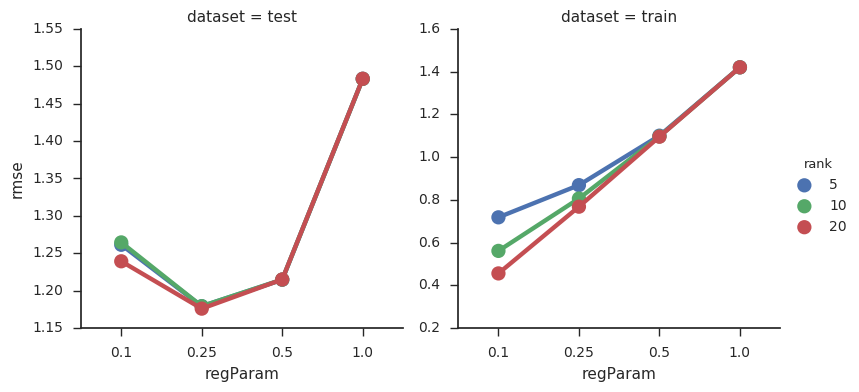

In [42]:
sns.factorplot(data=utils.concat_for_seaborn(scores), sharey=False, x="regParam", y="rmse", 
               hue="rank", col="dataset", col_order=["test", "train"])
plt.savefig("plots/scan_reg_rank_plain_als.pdf", bbox_inches="tight")

In der obigen Grafik sieht man das Ergebnis des Parametscans von regParam und rank. Der linke bzw. rechte Plot zeigt die Perfomance des Verfahrens auf dem Test- bzw. Trainings-Satz.

Im linken Plot, können wir die optimalen Parameter ablesen. Wir sehen das der beste Regularisierungs-Parameter bei $\lambda=0.25$ liegt. Die Dimension der Vektoren $\mathbf{Q}_u$, $\mathbf{P}_i$ hat bei diesem $\lambda$ kaum einen Einfluß.

Im rechten Plot sieht man, dass die "Performance" auf dem Trainings-Satz stets besser ist als auf dem Test-Satz. Dies ist normal. Außerdem sehen wir, dass die "Performance" mit sinkender Regularisierung immer besser wird. Dies ist auch zu erwarten, da mit sinkendender Regularisierung das Verfahren den Trainings-Satz immer besser auswendig lernen kann. Das zeigt, warum man die "Performance" auf dem Trainings-Satz nicht für die Auswahl der Meta-Parameter verwenden darf.

Der beste RMSE-Score ist 1.176. Der triviale Pädiktor hat 1.227. Wir sehen also eine Verbesserung um 0.051 oder um 4%. Dieses Ergebnis ist nicht gerade berauschend. Vielleicht können wir ja noch mehr rausholen.

## Daten um den Mittelwert bereinigen und an die Residuen fitten

Hier ziehen wir von den Daten den Mittelwert der Bewertungen ab, bevor wir das ALS Verfahren anwenden. Wir zentrieren sozusagen die Daten. Dadurch muss das ALS den Mittelwert nicht selbst lernen.

Die geschieht durch die Preprocessing-Funktion "subtract_mean". Die Postprocessing-Funktion "add_mean" addiert den Mittelwert zu dem ALS-Ergebnis hinzu, um eine richtige Vorhersage zu erhalten.

Die Fälle wo ALS keine Vorhersage machen kann, werden mit 0 aufgefüllt.

In [43]:
def subtract_mean(df, mean=average_rating, col="rating"):
    return df.withColumn(col, F.col(col) - mean)

def add_mean(df, mean=average_rating, col="prediction"):
    return df.withColumn(col, F.col(col) + mean)

In [44]:
%%time
parameters = dict(regParam=[0.1, 0.25, 0.5, 1.0], 
                  rank=[5, 10, 20],
                  maxIter=[20])
preprocessing = [subtract_mean]
postprocessing = [fillna_zero, add_mean, restrict_output]
scores = parameter_scan(ALS, parameters, pre=preprocessing, post=postprocessing,
                        save="cv_reg_rank_residual.pkl")

CPU times: user 3.86 s, sys: 1.42 s, total: 5.29 s
Wall time: 9min 23s


In [45]:
scores

,maxIter,rank,regParam,rmse_test,rmse_train
0,20,5,0.10,1.258868,0.733107
1,20,5,0.25,1.168670,0.882236
2,20,5,0.50,1.191979,1.120015
3,20,5,1.00,1.226535,1.229537
4,20,10,0.10,1.249237,0.564714
5,20,10,0.25,1.166196,0.814118
6,20,10,0.50,1.190239,1.112358
7,20,10,1.00,1.226532,1.229526
8,20,20,0.10,1.214371,0.456656
9,20,20,0.25,1.161553,0.773532


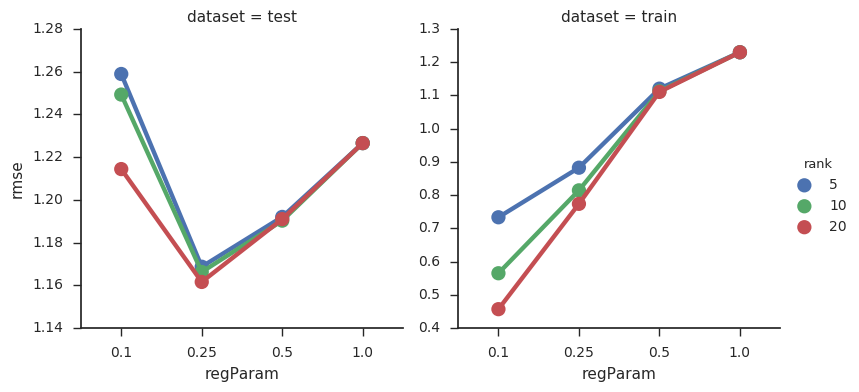

In [46]:
sns.factorplot(data=utils.concat_for_seaborn(scores), sharey=False, x="regParam", y="rmse", 
               hue="rank", col="dataset", col_order=["test", "train"])
plt.savefig("plots/scan_reg_rank_mu_als.pdf", bbox_inches="tight")

In der obigen Grafik sehen wir, dass der beste RMSE-Score dieses modifzierten Verfahrens bei 1.162 liegt. Dadurch haben wir uns gegebenüber dem normalen ALS um 0,015 oder 1,3% verbessert. Immer noch nicht berauschend, wir machen weiter ....

### User- und Itembias Vektoren

Es scheint, dass es dem ALS Verfahren gut tut, wenn man bekannte Information vor dem Trainieren abzieht. Motoviert daduch versuchen wir nun zusätzlich zum Mittelwert die *bedingten* Mittelwerte einfließen zu lassen.

In [1] wird folgender Ansatz als Modell genommen:
\begin{equation}
R_{ui} = \mu + b_u + b_i + \mathbf{Q}_u \cdot \mathbf{P}_i
\end{equation}
dabei sind $b_u$ und $b_i$ der Bias des Users $u$ und Items $i$. Diese beschreiben, ob ein User bzw.  Item tendenziell Bewertungen über oder unter dem Mittelwert vergibt bzw. erhält.

Hier wollen wir zunächst das einfachere Modell $\mu + b_u + b_i$ ausprobieren. In diesem Fall lassen sich $b_u$ und $b_i$ analytisch bestimmen. Vernachlässigt man die Regularisierung und fordert zusätzlich 

\begin{equation}
\sum_i b_i = 0 \\
\sum_u b_u = 0
\end{equation}

(es macht durchaus Sinn, dass die Bias-Verteilung zentriert ist), so erhält man durch Optimierung der Fehler-Funktion (d.h. $ dJ/db_i = 0, dJ/db_u = 0$) folgende Lösung

\begin{equation}
b_i = \frac{1}{n_u}\sum_{u\in K} (R_{ui} - \mu) \\
b_u = \frac{1}{n_i}\sum_{i\in K} (R_{ui} - \mu)
\end{equation}

Dies sind gerade die (zentrierten) bedingten Mittelwerte der Bewertungen. Diese werden im Folgenden berechnet und zur Vorhersage genutzt. 

Wir erhalten einen RMSE-Score von 1,124. Dies ist um 0,038 oder 3,2% besser als das Modell aus dem vorhergehenden Abschnitt ($R_{ui} = \mu + \mathbf{Q}_u \cdot \mathbf{P}_i$). 

**Hier haben wir also ohne jegliches ALS und numerische Optimierung ein besseres Modell erhalten. Hmm ....**

In [47]:
user_bias = train.groupBy("user").agg((F.mean("rating") - average_rating).alias("user_bias"))
user_bias.cache()
item_bias = train.groupBy("item").agg((F.mean("rating") - average_rating).alias("item_bias"))
item_bias.cache()
user_bias.show(5)

+----+--------------------+
|user|           user_bias|
+----+--------------------+
| 148|-0.42975192232855264|
| 463| 0.39524807767144754|
| 471|  0.1575122286148436|
| 496|  0.2785814110047804|
| 833| -0.9922519223285526|
+----+--------------------+
only showing top 5 rows



In [48]:
test_pred = (test
 .join(user_bias, "user", how="left")
 .join(item_bias, "item", how="left")
 .na.fill(0.0, ["user_bias", "item_bias"])
 .select("user", "item", "rating", 
         (F.lit(average_rating) + F.col("user_bias") + F.col("item_bias")).alias("prediction"))
    )

In [49]:
rmse.evaluate(test_pred)

1.1313808290868945

##### Einschränken des Output-Wertebereiches bringt Verbesserung

In [50]:
rmse.evaluate(restrict_output(test_pred))

1.1239333948858277

### Daten um Mittelwert und Bias-Vektoren bereinigen

Hier wollen wir nun das komplette Model
\begin{equation}
R_{ui} = \mu + b_u + b_i + \mathbf{Q}_u \cdot \mathbf{P}_i
\end{equation}
trainieren. Zu diesem Zweck ziehen vor dem Trainieren des ALS $\mu + b_u + b_i$ von den Daten ab und trainieren das ALS auf den Residuen. Dies wird durch die Funktion "subtract_mean_and_biases" bewerkstelligt. Die Funktion "add_mean_and_biases" addiert $\mu + b_u + b_i$ auf den Output von ALS wieder drauf.

#### Anmerkung
In [1] wird das gesammte obige Modell auf einmal gefittet und zusätzlich gibt es Regularisierungsterme für $b_u$ und $b_i$. Dort findet die Optimierung mit stochastic gradient descent statt. Da das ALS dies nicht kann, ermitteln wir hier die $b_u$ und $b_i$ vor dem Fitten, wie oben beschrieben.

In [51]:
def subtract_mean_and_biases(df, user_bias=user_bias, item_bias=item_bias, 
                             mean=average_rating, col="rating"):
    df = (df
          .join(user_bias, "user", how="left")
          .join(item_bias, "item", how="left")
          .withColumn(col, F.col(col) - mean - F.col("user_bias") - F.col("item_bias"))
         )
    return df

def add_mean_and_biases(df, user_bias=user_bias, item_bias=item_bias, 
                        mean=average_rating, col="prediction"):
    assert col == "prediction"
    df = (df
          .join(user_bias, "user", how="left")
          .join(item_bias, "item", how="left")
          .na.fill(0.0, ["user_bias", "item_bias", "prediction"])
          .withColumn("prediction", mean + F.col("user_bias") + F.col("item_bias") + F.col("prediction"))
         )
    return df

In [52]:
%%time
parameters = dict(regParam=[0.25, 0.5, 0.75, 1.0], 
                  rank=[5, 10, 20],
                  maxIter=[20])
preprocessing = [subtract_mean_and_biases]
postprocessing = [fillna_zero, add_mean_and_biases, restrict_output]
scores = parameter_scan(ALS, parameters, pre=preprocessing, post=postprocessing, 
                        save="cv_reg_rank_residual2.pkl")

CPU times: user 3.74 s, sys: 1.43 s, total: 5.16 s
Wall time: 9min 33s


In [53]:
scores

,maxIter,rank,regParam,rmse_test,rmse_train
0,20,5,0.25,1.139694,0.842088
1,20,5,0.50,1.123686,1.003507
2,20,5,0.75,1.123940,1.016574
3,20,5,1.00,1.123935,1.016696
4,20,10,0.25,1.136582,0.794518
5,20,10,0.50,1.123659,1.002653
6,20,10,0.75,1.123940,1.016573
7,20,10,1.00,1.123935,1.016696
8,20,20,0.25,1.129759,0.763501
9,20,20,0.50,1.123593,1.002267


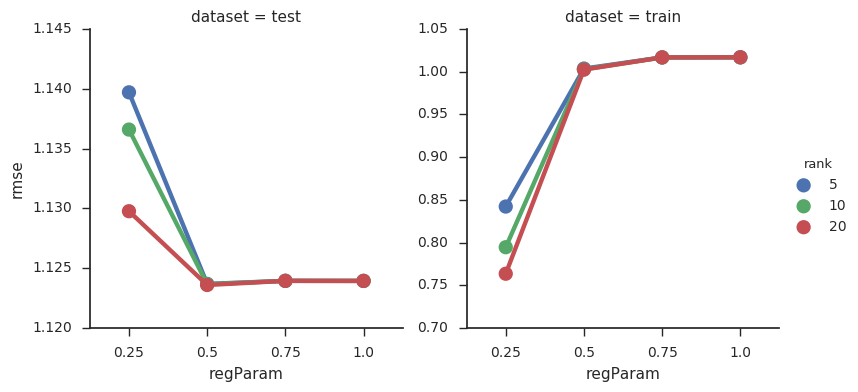

In [54]:
sns.factorplot(data=utils.concat_for_seaborn(scores), sharey=False, x="regParam", y="rmse", 
               hue="rank", col="dataset", col_order=["test", "train"])
plt.savefig("plots/scan_reg_rank_mu_bias_als.pdf", bbox_inches="tight")

Diese Modell erreicht einen RMSE-Score von 1,1236. Dies praktisch ist der gleiche Score wie im vorhergehenden Modell (1,1239). 

**Das ALS scheint also nichts aus den Residuen zu lernen.**

### Scan des Parameters rank

Im obigen linken Plot sieht man eine rapide Verbesserung der Vorhersage-Perfomance bei regParam=0,25 und steigendem rank. Vielleicht erreichen wir ja duch weitere Erhöhung von rank eine bessere Performance.

Im Folgenden sehen wir jedoch, das dies nicht der Fall ist. Das Modell mit rank=100 kommt auf einen ähnlichen Fehler wie das obige Modell. Eine weitere Erhöhung von rank steigert die Rechendauer enorm, deswegen gehen wir hier nicht weiter. Der Kurvenverlauf im unteren linken Plot deutet auch nicht auf eine starke Verbesserung mit weiter steigenedem "rank" hin.

In [55]:
%%time
parameters = dict(regParam=[0.25], 
                  rank=[5, 10, 30, 50, 70, 100],
                  maxIter=[20])
preprocessing = [subtract_mean_and_biases]
postprocessing = [fillna_zero, add_mean_and_biases, restrict_output]
scores = parameter_scan(ALS, parameters, pre=preprocessing, post=postprocessing, 
                        save="cv_rank_residual2.pkl")

CPU times: user 1.95 s, sys: 736 ms, total: 2.69 s
Wall time: 10min 2s


In [56]:
scores

,maxIter,rank,regParam,rmse_test,rmse_train
0,20,5,0.25,1.139694,0.842088
1,20,10,0.25,1.136582,0.794518
2,20,30,0.25,1.127573,0.752352
3,20,50,0.25,1.125508,0.743784
4,20,70,0.25,1.124926,0.740476
5,20,100,0.25,1.124348,0.738349


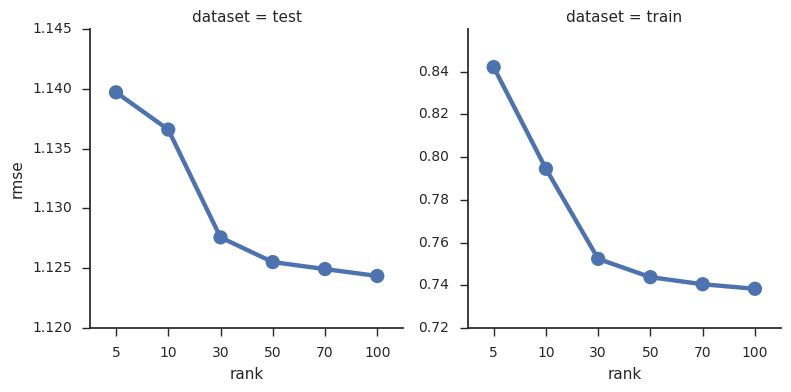

In [57]:
sns.factorplot(data=utils.concat_for_seaborn(scores), sharey=False, x="rank", y="rmse", 
               col="dataset", col_order=["test", "train"])
plt.savefig("scan_rank.pdf", bbox_inches="tight")

In [58]:
%%time
parameters = dict(regParam=[0.05, 0.1, 0.2], 
                  rank=[100],
                  maxIter=[20])
preprocessing = [subtract_mean_and_biases]
postprocessing = [fillna_zero, add_mean_and_biases, restrict_output]
scores = parameter_scan(ALS, parameters, pre=preprocessing, post=postprocessing, 
                        save="cv_reg_residual2.pkl")

CPU times: user 1 s, sys: 504 ms, total: 1.51 s
Wall time: 11min 31s


In [59]:
scores

,maxIter,rank,regParam,rmse_test,rmse_train
0,20,100,0.05,1.151730,0.259953
1,20,100,0.10,1.139805,0.385886
2,20,100,0.20,1.127137,0.632041


### Nochmaliger Scan von maxIter

Hier findet ein nochmaliger Parameterscan von maxIter statt, um sicherzustellen, dass beim bisher besten Modell die Wahl maxIter=20 noch ausreichend ist. Wir sehen, dass dies der Fall ist.

In [60]:
%%time
parameters = dict(regParam=[0.5], 
                  rank=[20],
                  maxIter=[5,10,20,30])
preprocessing = [subtract_mean_and_biases]
postprocessing = [fillna_zero, add_mean_and_biases, restrict_output]
scores = parameter_scan(ALS, parameters, pre=preprocessing, post=postprocessing)

CPU times: user 1.19 s, sys: 500 ms, total: 1.69 s
Wall time: 3min 15s


In [61]:
scores

,maxIter,rank,regParam,rmse_test,rmse_train
0,5,20,0.5,1.123656,1.006328
1,10,20,0.5,1.123627,1.004541
2,20,20,0.5,1.123593,1.002267
3,30,20,0.5,1.123586,1.001371


## Finaler Test des besten Models

Hier wird ein anderer Training-Test-Split gemacht und auf diesem nochmals der Fehler der Vorhersagen bestimmt. Dies ist notwendig, da durch die Auswahl der Meta-Parameter ein Overfitting auf dem speziellen Split stattfinden kann. 

(Alternativ hätte man einen ganz separaten Test-Satz vorhalten können, also einen Dreiersplit durchführen in training, validation und test.)

Wir sehen, dass der RMSE-Score mit 1,1223 sogar etas unter dem Wert von oben liegt 1,1236. Die "Verbesserung" ist aber nicht signifikant.

Das heißt unsere beste Schätzung für den RMSE-Fehlers des Vorhersageverfahrens ist 1,1236. <br>(Man könnte versuchen diesen z.B. durch k-fold-Kreuzvalidierung verlässlicher zu bestimmen.)

In [62]:
train, test = review_df.randomSplit([0.75,0.25], seed=7)
train.cache()
test.cache()

DataFrame[user: int, item: int, rating: float]

In [63]:
# average needs to be determined again
average_rating = train.agg(F.mean("rating")).first()[0]
average_rating

3.8066549534335063

In [64]:
# biases need to be determined again
user_bias = train.groupBy("user").agg((F.mean("rating") - average_rating).alias("user_bias"))
user_bias.cache()
item_bias = train.groupBy("item").agg((F.mean("rating") - average_rating).alias("item_bias"))
item_bias.cache()

DataFrame[item: int, item_bias: double]

In [65]:
# insert new average and biases into pre- and post-processing functions
subtract_mean_and_biases = partial(subtract_mean_and_biases, 
                                   user_bias=user_bias, 
                                   item_bias=item_bias, 
                                   mean=average_rating)

add_mean_and_biases = partial(add_mean_and_biases, 
                              user_bias=user_bias, 
                              item_bias=item_bias, 
                              mean=average_rating)

In [66]:
test_pred = (test
 .join(user_bias, "user", how="left")
 .join(item_bias, "item", how="left")
 .na.fill(0.0, ["user_bias", "item_bias"])
 .select("user", "item", "rating", 
         (F.lit(average_rating) + F.col("user_bias") + F.col("item_bias")).alias("prediction"))
    )

rmse.evaluate(restrict_output(test_pred))

1.1228643463288879

In [67]:
# parameter scan with new train-test-split
parameters = dict(regParam=[0.5], rank=[20], maxIter=[20])

preprocessing = [subtract_mean_and_biases]
postprocessing = [fillna_zero, add_mean_and_biases, restrict_output]

score = parameter_scan(ALS, parameters, pre=preprocessing, post=postprocessing, 
                       test=test, train=train)
score

,maxIter,rank,regParam,rmse_test,rmse_train
0,20,20,0.5,1.122349,1.001784


## Untersuchung der Fehler der Vorhersagen

Hier wollen wir die Fehler, die das Vorhersageverfahren macht, untersuchen. 

In [68]:
# train ALS with optimal parameters
als = ALS(regParam=0.25, rank=20, maxIter=20).fit(subtract_mean_and_biases(train))

In [69]:
pred_als = als.transform(test)

### Verteilung der Korrekturen durch das ALS

Zunächst schauen wir welche "Korrekturen" der ALS Teil des Verfahrens zusätzlich zu dem einfacheren Modell $\mu + b_u + b_i$ macht. Wir gucken uns also nur den Output von $\mathbf{Q}_u \cdot \mathbf{P}_i$ an. Die Verteilung dieser Korrekturen ist symmeterisch und um null zentriert. Die Korrekturen liegen im Bereich von -0.5 bis 0.5 und sind meißt relativ klein. Insgesammt sieht die Verteilung der Korrekturen OK aus.

In [70]:
bins, counts = (pred_als
                .select("prediction")
                .rdd.keys()
                .histogram(list(np.linspace(-2,2,30))))

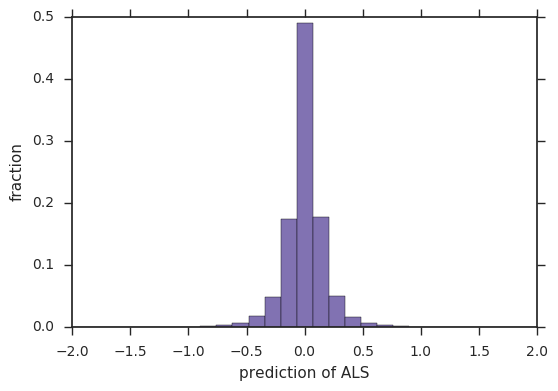

In [71]:
utils.plot_histogram(bins, counts, "prediction of ALS", seaborn=False, color=utils.purple)
plt.savefig("plots/histogram_als_output.pdf", bbox_inches="tight")

### Verteilung der vorhergesagten und realen Bewertungen

In [72]:
prediction = \
    restrict_output(
        add_mean_and_biases(
            fillna_zero(
                als.transform(test)))).cache()

In [73]:
prediction_bias_only = \
    restrict_output(
        add_mean_and_biases(
            fillna_zero(
                test.withColumn("prediction", F.lit(0))))).cache()

In [74]:
bins = [1,2,3,4,5,6]
bins1, count1 = prediction.select("prediction").rdd.keys().histogram(bins)
bins2, count2 = prediction_bias_only.select("prediction").rdd.keys().histogram(bins)
bins3, count3 = prediction.select("rating").rdd.keys().histogram(bins)

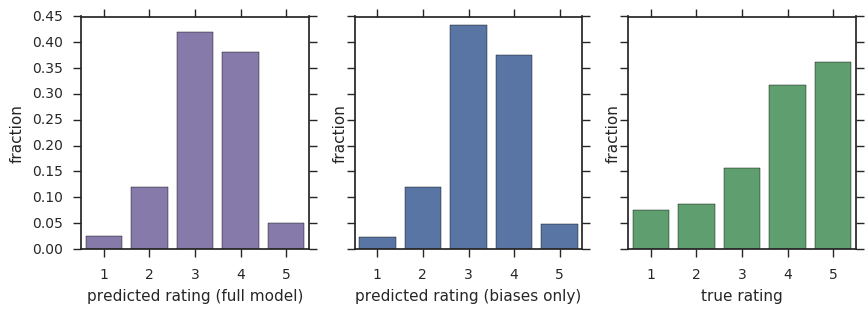

In [75]:
f, axs = plt.subplots(1,3,sharey=True, figsize=(10,3))
plt.sca(axs[0])
utils.plot_histogram(bins1, count1, "predicted rating (full model)", color=utils.purple)
plt.sca(axs[1])
utils.plot_histogram(bins2, count2, "predicted rating (biases only)", color=utils.blue)
plt.sca(axs[2])
utils.plot_histogram(bins3, count3, "true rating", color=utils.green)
plt.savefig("plots/histogram_rating_pred_and_true.pdf", bbox_inches="tight")

Die obigen drei Plots zeigen die Verteilung der Bewertungen für das volle Modell ($\mu + b_u + b_i + \mathbf{Q}_u \cdot \mathbf{P}_i$), das rein auf Bias-Vektoren basierende Modell ($\mu + b_u + b_i$) und die tatsächlichen Bewertungen.

Die ersten beiden Verteilung sind praktisch gleich. Das heißt, die ALS Komponente hat (zumindest) auf diese Eigenschaft der Vorhersagen keinen Einfluss.

Wir sehen, dass die Verteilung der vorhergesagten Bewertungen stark von der Verteilung der realen Bewertungen abweicht. Die reale Verteilung ist stark zu dem Wert 5 verschoben. Die vorhergesagten Verteilungen sind eher um dem Mittelwert $\mu$ zentriert.

Diese Beobachtung mag für das Modell $\mu + b_u + b_i$ nicht ganz überraschend sein. Es basiert ja auf dem Mittelwert und den bedingten Mittelwerten.

Es ist aber sehr verwunderlich, dass die ALS Komponente es scheinbar nicht schafft hier eine Verbesserung zu erreichen.

### Verteilung des Fehler des Vorhersagen

In [76]:
bins = list(range(-5,7))
bins1, count1 = prediction.select(F.col("prediction")-F.col("rating")).rdd.keys().histogram(bins)
bins2, count2 = prediction_bias_only.select(F.col("prediction")-F.col("rating")).rdd.keys().histogram(bins)

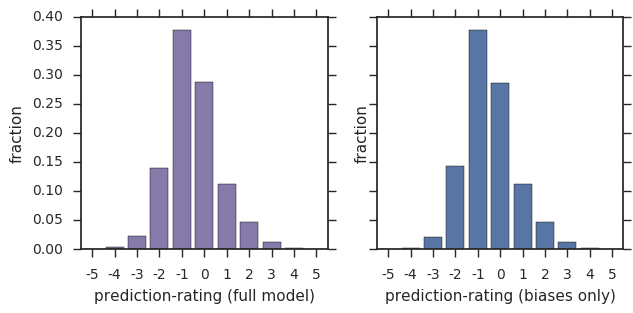

In [77]:
f, axs = plt.subplots(1,2,sharey=True, figsize=(7,3))
plt.sca(axs[0])
utils.plot_histogram(bins1, count1, "prediction-rating (full model)", color=utils.purple)
plt.sca(axs[1])
utils.plot_histogram(bins2, count2, "prediction-rating (biases only)", color=utils.blue)
plt.savefig("plots/histogram_pred_error.pdf", bbox_inches="tight")

## Untersuchung der Vektoren $Q$ und $P$

Hier sollen die gelernten Vektoren $\mathbf{Q}_u$ und $\mathbf{P}_i$ untersucht werden.

In [78]:
vector_lengths_user = als.itemFactors.rdd.map(lambda r: np.sqrt(np.dot(r[1],r[1]))).collect()
vector_lengths_item = als.userFactors.rdd.map(lambda r: np.sqrt(np.dot(r[1],r[1]))).collect()

### Verteilung der Längen der Vektoren

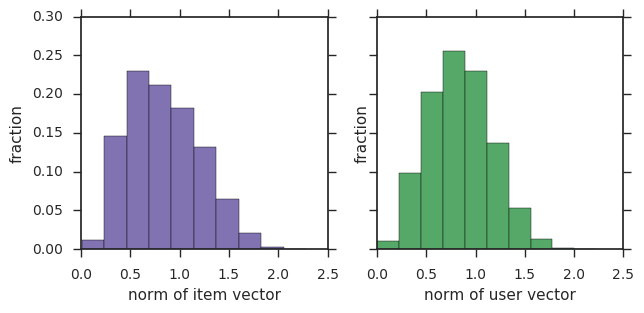

In [79]:
f, axs = plt.subplots(1,2,sharey=True, figsize=(7,3))
plt.sca(axs[0])
counts, bins = plt.histogram(vector_lengths_item)
utils.plot_histogram(bins, counts, "norm of item vector", seaborn=False, color=utils.purple)
plt.sca(axs[1])
counts, bins = plt.histogram(vector_lengths_user)
utils.plot_histogram(bins, counts, "norm of user vector", seaborn=False, color=utils.green)

## Empfehlungen erstellen

Das bisher trainierte Verfahren macht Vorhersagen für die Bewertugen von Items, die der User noch nicht bewertet hat. Das Verfahren erlaubt es also die komplete Matrix $R_{ui}$ zu bestimmen.

Daraus müssen jedoch Empfehlungen erst abgeleitet werden. Um die Empfehlungen für User $u$ zu berechnen verfahren wir wie folgt:

1. Berechnen der Bewertungen $R_{ui}$ für **bisher nicht bewertete** Items, d.h. $u,i\notin K$
2. Sortierung von diesen $R_{ui}$ bezüglich $i$ in absteigender Reihenfolge ($u$ ist fest)
3. Die Items mit den 5 höchsten Bewertungen werden empfohlen

Dieses Vorgehen wird in der Funktion "get_suggestions" umgesetzt. Sie berechnet die Empfehlungen gleichzeitig für eine gewisse Menge von Usern. Dies ist deutlich schneller als die Berechnung für jeden User einzeln durchzuführen (Benchmarks hier nicht gezeigt). Diese Menge darf aber nicht zu groß sein, da der Teil der Matrix $R_{ui}$ der berechnet wird sonst zu groß wird und nicht in den Arbeitsspeicher passt.

Die Berechnung für 100 User dauert 24 Sekunden. Für die gesamte Anzahl der User 42893 würde das 2,9 Stunden dauern.

Zusätlich zum hier implementierten Vorgehen, wäre es nützlich den Nutzern nur Geschäfte in ihrer Nähe zu empfehlen. Dazu würde man die Items vorher nach der Entfernung zur Geo-Position des Nutzers filtern (im Yelp Datensatz sind die Geo-Positionen der Geschäfte angegeben). Falls die Geo-Position des Nutzers nicht direkt bekannt ist, könnte man statt dessen die Geo-Position des zuletzt durch den Nutzer bewerteten Geschäfts nehmen.

### Finales Modell auf dem gesamten Datensatz trainieren

In [80]:
# fit final model on the complete data set

# mean
average_rating = review_df.agg(F.mean("rating")).first()[0]

# bias vectors
user_bias = review_df.groupBy("user").agg((F.mean("rating") - average_rating).alias("user_bias"))
user_bias.cache()
item_bias = review_df.groupBy("item").agg((F.mean("rating") - average_rating).alias("item_bias"))
item_bias.cache()

# insert new average and biases into pre- and post-processing functions
subtract_mean_and_biases = partial(subtract_mean_and_biases, 
                                   user_bias=user_bias, 
                                   item_bias=item_bias, 
                                   mean=average_rating)

add_mean_and_biases = partial(add_mean_and_biases, 
                              user_bias=user_bias, 
                              item_bias=item_bias, 
                              mean=average_rating)

# fit ALS
final_model_als = ALS(rank=10, regParam=0.25, maxIter=10).fit(subtract_mean_and_biases(review_df))

### Empfehlungen berechnen

In [81]:
users = review_df.select("user").distinct().orderBy("user").collect()
users = list(map(lambda r: r[0], users))
items = review_df.select("item").distinct().cache()

In [82]:
def get_suggestions(previous_ratings, make_prediction, items, users):
    assert len(users) * items.count() < 10**7
    
    #convert users list to a DataFrame
    users_ = [(u,) for u in users]
    users_ = sqlc.createDataFrame(users_, ["user"])
    
    #cartesian product
    pairs = items.join(users_)
    
    #subtract items which have been rated already
    previous_ratings = previous_ratings.filter(F.col("user").isin(users))
    pairs = pairs.subtract(previous_ratings.select("user", "item"))
    
    prediction = make_prediction(pairs)
    
    #extract 5 items per user with the highest predicted rating
    window = Window.partitionBy("user").orderBy(F.col("prediction").desc())
    suggestions = (prediction
                  .withColumn("rank", F.rank().over(window))
                  .filter(F.col("rank")<=5))
    
    return suggestions

Das Andwenden der Funktion restrict_output wird an dieser Stelle bewusst weggelassen. So behält man die Ordnung der Items die das Verfahren vorschlägt bei, z.B. wird eine vorhergesagte Bewertung von 6 als höher-rangig bewertet als eine Bewertung von 5.

In [83]:
def make_prediction(df):
    prediction = \
            add_mean_and_biases(
                fillna_zero(
                    final_model_als.transform(df))).cache()
    return prediction

In [84]:
%%time
n_users_suggest = 100
suggestions = get_suggestions(
    review_df, 
    make_prediction, 
    items, 
    [users[i] for i in range(n_users_suggest)])

suggestions.show(10)

+-----+----+------------------+-------------------+------------------+----+
| item|user|        prediction|          user_bias|         item_bias|rank|
+-----+----+------------------+-------------------+------------------+----+
|12827|  26| 6.168722377562295|  0.583023176932107|1.1941342880432178|   1|
|12773|  26|6.0421860082385646|  0.583023176932107|1.1941342880432178|   2|
| 4484|  26| 6.020412044071923|  0.583023176932107|1.1941342880432178|   3|
|13196|  26| 5.984836654209863|  0.583023176932107|1.1941342880432178|   4|
|21985|  26| 5.953138546490441|  0.583023176932107|1.1941342880432178|   5|
| 8230|  29| 5.842332773417668|0.44413428804321775|1.1941342880432178|   1|
|12788|  29| 5.770171098918157|0.44413428804321775|1.1941342880432178|   2|
| 7532|  29| 5.747378282756047|0.44413428804321775|1.1941342880432178|   3|
| 6070|  29| 5.716562204570012|0.44413428804321775|1.1941342880432178|   4|
|18552|  29| 5.707805000752645|0.44413428804321775|1.1941342880432178|   5|
+-----+----+

## Fazit

Wir haben hier ein Empfehlungssystem auf dem Yelp-Datensatz trainiert. Dabei haben wir ein Matrix-Faktorisierungs-Modell mittels ALS trainiert. Das beste Modell hat den RMSE-Score gegenüber dem trivialen Prädiktor um ca. 0,1 verbessert, dies entspricht ca. 8%. Diese Verbesserung ist nicht sehr zufrieden stellend. Insbesondere, da sie auch ohne Matrix-Faktorisierung und ALS erreicht werden kann (durch das Modell mit den Bias Vektoren).

Dieses Notebook wurde auch auf dem MovieLens Datensatz ausgeführt. Dort hat eine deutlich stärkere Verbesserung des RMSE stattgefunden, nämlich um 0,26 bzw. um 23%. Dort war auch der Einsatz der Matrix-Faktorisierung und des ALS essentiell.

Es gibt einen offensichtlichen Unterschied zwischen den Datensätzen. Der MovieLens Datensatz hat viel weniger User und Items, um einen Faktor von ca. 7. Dies reduziert natürlich die Anzahl der Vektoren $\mathbf{Q}_{u},\mathbf{P}_{i}$ und damit die Anzahl der Parameter des Modells.

## Weitere mögliche Schritte

- Untersuchen, ob durch eine weitere Reduktion der User und Items das ALS Verfahren bessere Ergebnisse liefert (ähnlich wie auf dem MovieLens Datensatz)

- Idealerweise sollten sowohl die Vektoren $\mathbf{Q}_{u},\mathbf{P}_{i}$ wie auch die Bias-Terme $b_i, b_u$ gleichzeitig gelernt werden. Und zusätzlich sollten die Bias-Terme auch regularisiert werden. Dazu müsste man entweder das ALS-Verfahren anpassen oder mittels Stochastic Gradient Descent trainieren.

- Deutlich höhere Werte des rank Parameters ausprobieren

- Alternative collaborative filtering Ansätze ausprobieren

- Content basierte Empfehlungs-Systeme ausprobieren

## Gesamte Laufzeit des Notebooks

In [85]:
print("{:.1f} hours".format((time.time() - start_time)/3600))

1.1 hours


Das Notebook wurde auf einem VPS von Digital Ocean ausgeführt, dieser hat 8 (virtuelle) Cores und 16 GB RAM.